<a href="https://colab.research.google.com/github/kalyani234/RCT_NLP_CW1/blob/main/RCT_NLP_CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud
import seaborn as sns

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
dataset_path = '/content/drive/MyDrive/NLP_RCT_Dataset/rct_data.txt'

In [15]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation and typographical symbols, replace with space
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces and strip leading/trailing spaces
    words = word_tokenize(text)  # Tokenize sentences
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stop words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return ' '.join(words)  # Join tokens into a single string

In [18]:
# Read dataset from txt file
df = pd.read_csv(dataset_path, delimiter='\t', header=None, names=['ID', 'Label', 'Year', 'Title', 'Abstract'])


In [19]:
print("No of Rows: {}".format(df.shape[0]))
print("No of Columns: {}".format(df.shape[1]))

print("\nData View :\n")
print(df.head())

No of Rows: 27063
No of Columns: 5

Data View :

         ID  Label  Year                                              Title  \
0  18439781      0  2011  Two patients subdued with a TASER® device: cas...   
1  18468833      0  2011  A case of Takayasu arteritis causing subclavia...   
2  18481181      0  2012  Pathophysiology of hypopituitarism in the sett...   
3  18728056      1  2011  The cardiovascular risk factor, soluble CD40 l...   
4  18790590      0  2011         Horner syndrome due to carotid dissection.   

                                            Abstract  
0  In the United States, an increasing number of ...  
1  The American Heart Association website defines...  
2  The complex pathophysiology of traumatic brain...  
3  [BACKGROUND] Soluble CD40 ligand (sCD40L) is a...  
4  [BACKGROUND] Internal carotid artery dissectio...  


In [20]:
#Trim unnecessary spaces for strings
df["Title"] = df["Title"].apply(lambda x: x.strip() if isinstance(x, str) else x)
df["Abstract"] = df["Abstract"].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [21]:
df=df.dropna()
print("No of Rows: {}".format(df.shape[0]))
print("No of Columns: {}".format(df.shape[1]))

print("\nData View :\n")
print(df.head())

No of Rows: 27063
No of Columns: 5

Data View :

         ID  Label  Year                                              Title  \
0  18439781      0  2011  Two patients subdued with a TASER® device: cas...   
1  18468833      0  2011  A case of Takayasu arteritis causing subclavia...   
2  18481181      0  2012  Pathophysiology of hypopituitarism in the sett...   
3  18728056      1  2011  The cardiovascular risk factor, soluble CD40 l...   
4  18790590      0  2011         Horner syndrome due to carotid dissection.   

                                            Abstract  
0  In the United States, an increasing number of ...  
1  The American Heart Association website defines...  
2  The complex pathophysiology of traumatic brain...  
3  [BACKGROUND] Soluble CD40 ligand (sCD40L) is a...  
4  [BACKGROUND] Internal carotid artery dissectio...  


In [22]:
# Combine title and abstract into one column
df['text'] = df['Title'] + ' ' + df['Abstract']

In [23]:
# Print before preprocessing
print("Before Preprocessing:")
print(df['text'].head())

Before Preprocessing:
0    Two patients subdued with a TASER® device: cas...
1    A case of Takayasu arteritis causing subclavia...
2    Pathophysiology of hypopituitarism in the sett...
3    The cardiovascular risk factor, soluble CD40 l...
4    Horner syndrome due to carotid dissection. [BA...
Name: text, dtype: object


In [24]:
# Apply preprocessing
tqdm.pandas()  # Initialize tqdm for progress bar
df['processed_text'] = df['text'].progress_apply(preprocess_text)

100%|██████████| 27063/27063 [14:26<00:00, 31.25it/s]


In [25]:
# Print after preprocessing
print("\nAfter Preprocessing:")
print(df['processed_text'].head())





After Preprocessing:
0    two patient subdued taser device case review c...
1    case takayasu arteritis causing subclavian ste...
2    pathophysiology hypopituitarism setting brain ...
3    cardiovascular risk factor soluble cd40 ligand...
4    horner syndrome due carotid dissection backgro...
Name: processed_text, dtype: object


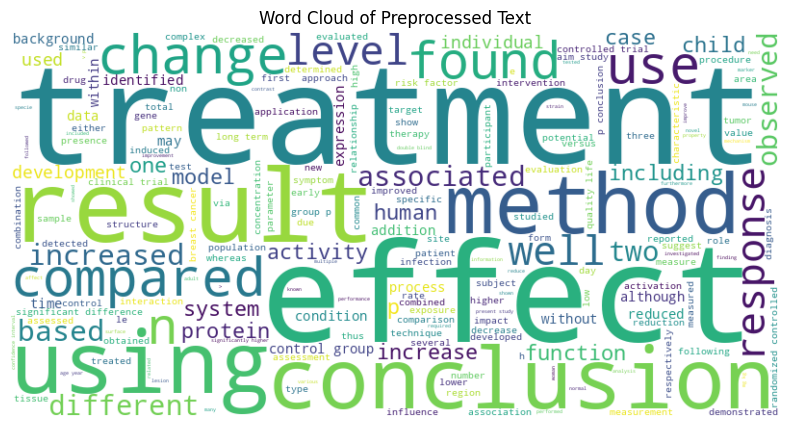

In [26]:
# Word Cloud visualization for preprocessed text
all_text = ' '.join(df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Text')
plt.show()

In [27]:
# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(df['processed_text'], df['Label'], test_size=0.2, random_state=42)



In [28]:
# Print the shape and number of columns
print("\nTraining data shape:", train_texts.shape, "Number of columns:", len(train_texts))
print("Test data shape:", test_texts.shape, "Number of columns:", len(test_texts))


Training data shape: (21650,) Number of columns: 21650
Test data shape: (5413,) Number of columns: 5413


In [29]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)

# Print the shape of the TF-IDF vectors
print("TF-IDF vectorized training data shape:", X_train_tfidf.shape)
print("TF-IDF vectorized test data shape:", X_test_tfidf.shape)

TF-IDF vectorized training data shape: (21650, 81264)
TF-IDF vectorized test data shape: (5413, 81264)


In [30]:
# Train SVM
svm_clf = SVC(kernel='linear', random_state=42, probability=True)
svm_clf.fit(X_train_tfidf, train_labels)
y_pred_svm = svm_clf.predict(X_test_tfidf)
y_proba_svm = svm_clf.predict_proba(X_test_tfidf)[:, 1]

In [31]:
# Train Logistic Regression
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train_tfidf, train_labels)
y_pred_lr = lr_clf.predict(X_test_tfidf)
y_proba_lr = lr_clf.predict_proba(X_test_tfidf)[:, 1]



In [32]:
# Train Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train_tfidf, train_labels)
y_pred_gb = gb_clf.predict(X_test_tfidf)
y_proba_gb = gb_clf.predict_proba(X_test_tfidf)[:, 1]



In [33]:
# Evaluation metrics for SVM
svm_accuracy = accuracy_score(test_labels, y_pred_svm)
svm_precision = precision_score(test_labels, y_pred_svm)
svm_recall = recall_score(test_labels, y_pred_svm)
svm_f1 = f1_score(test_labels, y_pred_svm)

# Evaluation metrics for Logistic Regression
lr_accuracy = accuracy_score(test_labels, y_pred_lr)
lr_precision = precision_score(test_labels, y_pred_lr)
lr_recall = recall_score(test_labels, y_pred_lr)
lr_f1 = f1_score(test_labels, y_pred_lr)

# Evaluation metrics for Gradient Boosting
gb_accuracy = accuracy_score(test_labels, y_pred_gb)
gb_precision = precision_score(test_labels, y_pred_gb)
gb_recall = recall_score(test_labels, y_pred_gb)
gb_f1 = f1_score(test_labels, y_pred_gb)



In [34]:
# Print metrics for all models
print("SVM Metrics:")
print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"F1 Score: {svm_f1}")

print("\nLogistic Regression Metrics:")
print(f"Accuracy: {lr_accuracy}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1}")

print("\nGradient Boosting Metrics:")
print(f"Accuracy: {gb_accuracy}")
print(f"Precision: {gb_precision}")
print(f"Recall: {gb_recall}")
print(f"F1 Score: {gb_f1}")



SVM Metrics:
Accuracy: 0.9325697395159801
Precision: 0.8822947576656776
Recall: 0.7838312829525483
F1 Score: 0.8301535597952535

Logistic Regression Metrics:
Accuracy: 0.9235174579715499
Precision: 0.8875802997858673
Recall: 0.7284710017574693
F1 Score: 0.8001930501930501

Gradient Boosting Metrics:
Accuracy: 0.9445778680953261
Precision: 0.9275510204081633
Recall: 0.7987697715289982
F1 Score: 0.8583569405099151


In [35]:
# Collect metrics
metrics = {
    'Model': ['SVM', 'Logistic Regression', 'Gradient Boosting'],
    'Accuracy': [svm_accuracy, lr_accuracy, gb_accuracy],
    'Precision': [svm_precision, lr_precision, gb_precision],
    'Recall': [svm_recall, lr_recall, gb_recall],
    'F1 Score': [svm_f1, lr_f1, gb_f1]
}

metrics_df = pd.DataFrame(metrics)

# Plot metrics
plt.figure(figsize=(16, 12))



<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

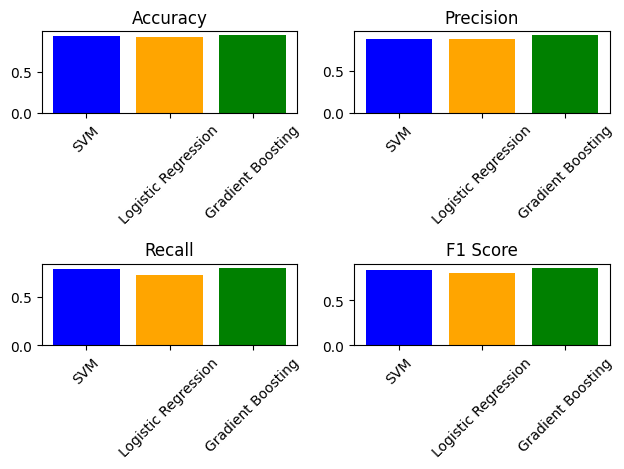

In [36]:
# Create subplots for each metric
plt.subplot(2, 2, 1)
plt.bar(metrics_df['Model'], metrics_df['Accuracy'], color=['blue', 'orange', 'green'])
plt.title('Accuracy')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.bar(metrics_df['Model'], metrics_df['Precision'], color=['blue', 'orange', 'green'])
plt.title('Precision')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.bar(metrics_df['Model'], metrics_df['Recall'], color=['blue', 'orange', 'green'])
plt.title('Recall')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.bar(metrics_df['Model'], metrics_df['F1 Score'], color=['blue', 'orange', 'green'])
plt.title('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



Confusion Matrices:

SVM Confusion Matrix:
[[4156  119]
 [ 246  892]]

Logistic Regression Confusion Matrix:
[[4170  105]
 [ 309  829]]

Gradient Boosting Confusion Matrix:
[[4204   71]
 [ 229  909]]


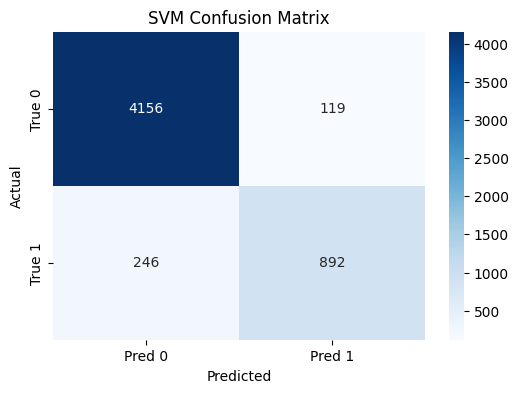

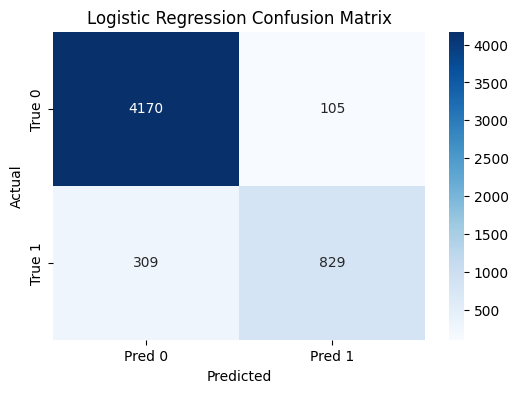

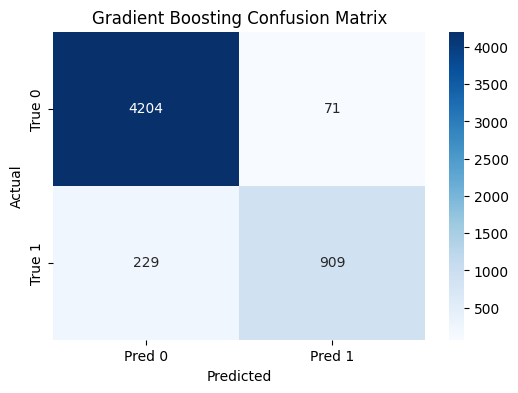

In [41]:
# Confusion Matrix for each model
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

cm_svm = confusion_matrix(test_labels, y_pred_svm)
cm_lr = confusion_matrix(test_labels, y_pred_lr)
cm_gb = confusion_matrix(test_labels, y_pred_gb)

print("Confusion Matrices:")
print("\nSVM Confusion Matrix:")
print(cm_svm)
print("\nLogistic Regression Confusion Matrix:")
print(cm_lr)
print("\nGradient Boosting Confusion Matrix:")
print(cm_gb)

plot_confusion_matrix(cm_svm, 'SVM Confusion Matrix')
plot_confusion_matrix(cm_lr, 'Logistic Regression Confusion Matrix')
plot_confusion_matrix(cm_gb, 'Gradient Boosting Confusion Matrix')




ROC AUC Scores:
SVM: 0.9634713614733965
Logistic Regression: 0.9637143238882208
Gradient Boosting: 0.9675966865024306


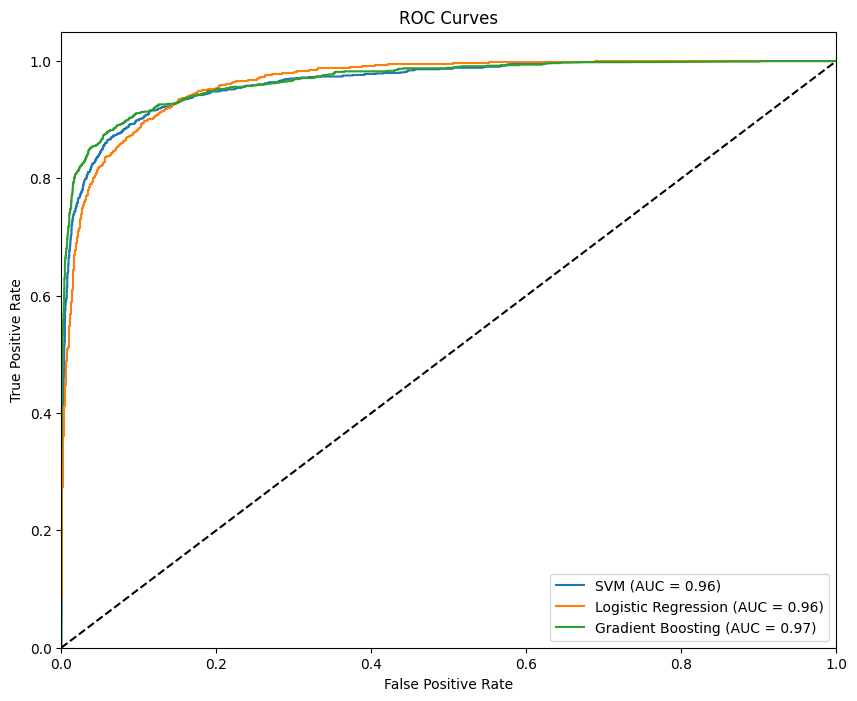

In [50]:
# ROC Curves
fpr_svm, tpr_svm, _ = roc_curve(test_labels, y_proba_svm)
fpr_lr, tpr_lr, _ = roc_curve(test_labels, y_proba_lr)
fpr_gb, tpr_gb, _ = roc_curve(test_labels, y_proba_gb)

roc_auc_svm = roc_auc_score(test_labels, y_proba_svm)
roc_auc_lr = roc_auc_score(test_labels, y_proba_lr)
roc_auc_gb = roc_auc_score(test_labels, y_proba_gb)

print("\nROC AUC Scores:")
print(f"SVM: {roc_auc_svm}")
print(f"Logistic Regression: {roc_auc_lr}")
print(f"Gradient Boosting: {roc_auc_gb}")

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()



Average Precision Scores:
SVM: 0.9084907191022764
Logistic Regression: 0.8924511718143181
Gradient Boosting: 0.9267214343954736


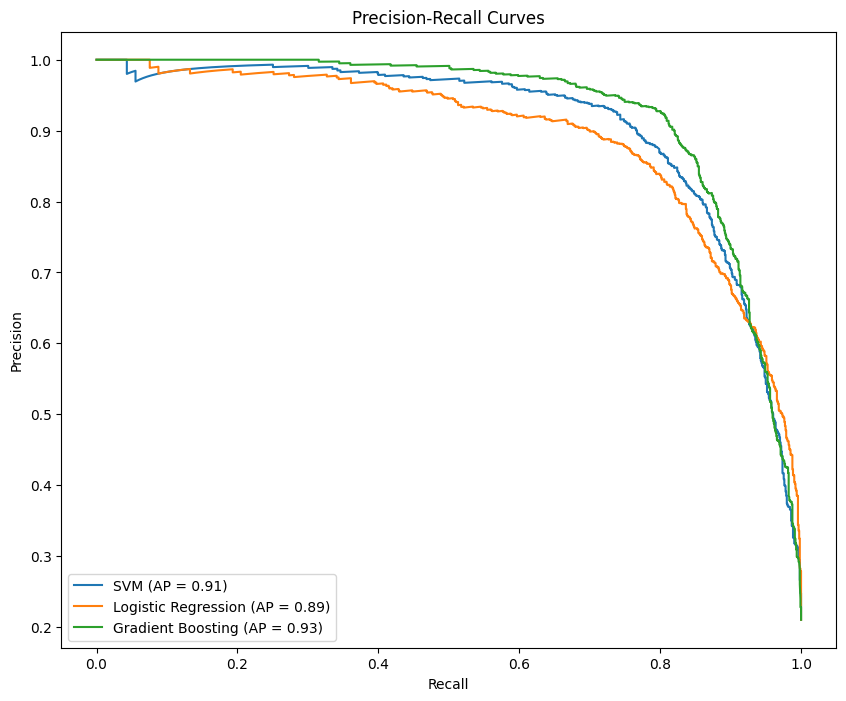

In [49]:
# Precision-Recall Curve for each model
# Precision-Recall Curves
precision_svm, recall_svm, _ = precision_recall_curve(test_labels, y_proba_svm)
precision_lr, recall_lr, _ = precision_recall_curve(test_labels, y_proba_lr)
precision_gb, recall_gb, _ = precision_recall_curve(test_labels, y_proba_gb)

average_precision_svm = average_precision_score(test_labels, y_proba_svm)
average_precision_lr = average_precision_score(test_labels, y_proba_lr)
average_precision_gb = average_precision_score(test_labels, y_proba_gb)

print("\nAverage Precision Scores:")
print(f"SVM: {average_precision_svm}")
print(f"Logistic Regression: {average_precision_lr}")
print(f"Gradient Boosting: {average_precision_gb}")

plt.figure(figsize=(10, 8))
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {average_precision_svm:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {average_precision_lr:.2f})')
plt.plot(recall_gb, precision_gb, label=f'Gradient Boosting (AP = {average_precision_gb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()